In [206]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import cvxpy as cp
from scipy.stats import poisson, uniform, expon, pareto
from scipy.optimize import minimize, fsolve, least_squares
import scipy as sc
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

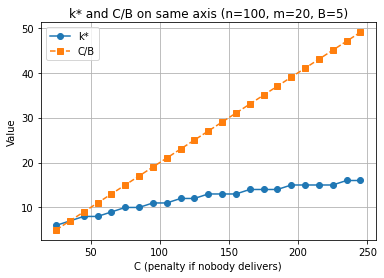

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
n, m, B = 100, 20, 5

def expected_cost(n, m, C, B, k):
    sybils = n - m
    if k > n:
        return float("inf")
    if k > sybils:
        P0 = 0.0
    else:
        P0 = math.comb(sybils, k) / math.comb(n, k)
    return P0 * (C - k * B) + (1 - P0) * k

def optimal_k(n, m, C, B):
    best_k = None
    best_cost = float("inf")
    for k in range(1, n + 1):
        cost = expected_cost(n, m, C, B, k)
        if cost < best_cost - 1e-12:
            best_cost = cost
            best_k = k
    return best_k

# Compute data
records = []
for C in range(25, 251, 10):
    k_star = optimal_k(n, m, C, B)
    records.append({"C": C, "k_star": k_star, "C_over_B": C / B})

df3 = pd.DataFrame(records)

# Plot on same y-axis
plt.figure()
plt.plot(df3["C"], df3["k_star"], marker='o', label="k*")
plt.plot(df3["C"], df3["C_over_B"], marker='s', linestyle='--', label="C/B")
plt.xlabel("C (penalty if nobody delivers)")
plt.ylabel("Value")
plt.title("k* and C/B on same axis (n=100, m=20, B=5)")
plt.legend()
plt.grid(True)
plt.show()


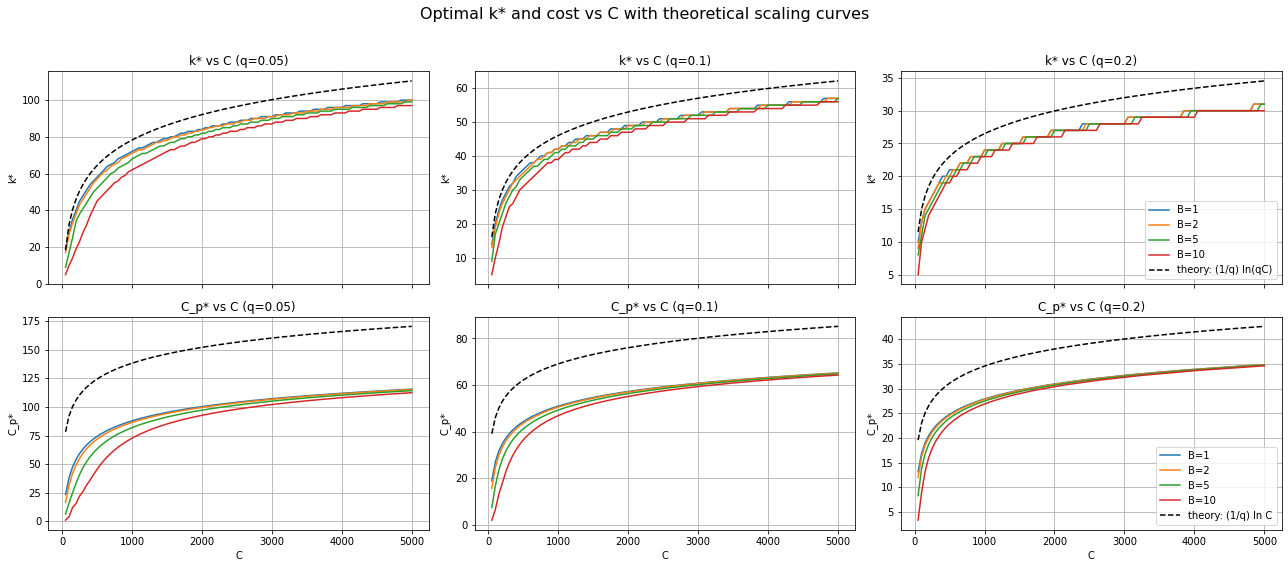

In [3]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Parameters
n = 500
q_values = [0.05, 0.1, 0.2]
B_values = [1, 2, 5, 10]
C_min, C_max, C_step = 50, 5000, 50
C_values = list(range(C_min, C_max + C_step, C_step))

def expected_cost(n, m, C, B, k):
    sybils = n - m
    if k > n:
        return float("inf")
    if k > sybils:
        P0 = 0.0
    else:
        P0 = math.comb(sybils, k) / math.comb(n, k)
    return P0 * (C - k * B) + (1 - P0) * k

def optimal_k(n, m, C, B):
    k_max = min(n, math.ceil(C / (1 + B)))
    best_k, best_cost = None, float("inf")
    for k in range(1, k_max + 1):
        cost = expected_cost(n, m, C, B, k)
        if cost < best_cost - 1e-12:
            best_cost, best_k = cost, k
    return best_k, best_cost

# Precompute
records = []
for q in q_values:
    m = int(round(q * n))
    for B in B_values:
        for C in C_values:
            k_star, cost_star = optimal_k(n, m, C, B)
            # Leading-order asymptotic predictions (independent of B)
            k_pred = (1.0 / q) * math.log(C * q)
            cost_pred = (1.0 / q) * math.log(C)
            records.append({
                "q": q, "m": m, "B": B, "C": C,
                "k_star": k_star, "cost_star": cost_star,
                "k_pred": k_pred, "cost_pred": cost_pred
            })

df = pd.DataFrame(records)

# 2x3 grid with theoretical lines (same for all B so plot once per q)
fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex='col')

for col, q in enumerate(q_values):
    dfq = df[df.q == q]
    # k* panel
    ax_k = axes[0, col]
    for B in B_values:
        sub = dfq[dfq.B == B]
        ax_k.plot(sub["C"], sub["k_star"], label=f"B={B}")
    # theoretical
    k_pred_series = dfq[dfq.B == B_values[0]].groupby("C")["k_pred"].first()
    ax_k.plot(k_pred_series.index, k_pred_series.values, 'k--', linewidth=1.5, label="theory: (1/q) ln(qC)")
    ax_k.set_title(f"k* vs C (q={q})")
    ax_k.set_ylabel("k*")
    ax_k.grid(True)
    if col == 2:
        ax_k.legend(loc="lower right")

    # cost panel
    ax_c = axes[1, col]
    for B in B_values:
        sub = dfq[dfq.B == B]
        ax_c.plot(sub["C"], sub["cost_star"], label=f"B={B}")
    cost_pred_series = dfq[dfq.B == B_values[0]].groupby("C")["cost_pred"].first()
    ax_c.plot(cost_pred_series.index, cost_pred_series.values, 'k--', linewidth=1.5, label="theory: (1/q) ln C")
    ax_c.set_title(f"C_p* vs C (q={q})")
    ax_c.set_xlabel("C")
    ax_c.set_ylabel("C_p*")
    ax_c.grid(True)
    if col == 2:
        ax_c.legend(loc="lower right")

fig.suptitle("Optimal k* and cost vs C with theoretical scaling curves", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


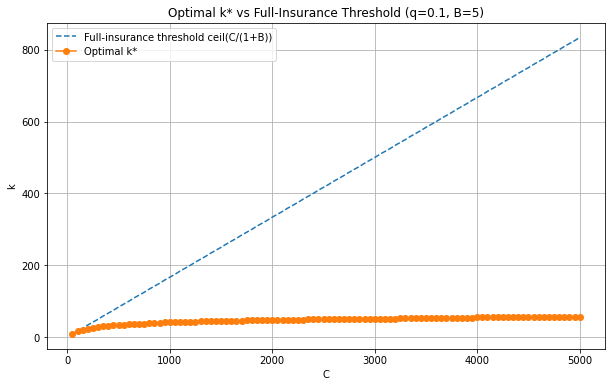

In [4]:
import math
import matplotlib.pyplot as plt

# Parameters (you can adjust these)
n = 500          # total identities
q = 0.1          # honest fraction m/n
B = 5            # per-identity slash budget
C_min, C_max, C_step = 50, 5000, 50
C_values = list(range(C_min, C_max + C_step, C_step))
m = int(round(q * n))

def expected_cost(n, m, C, B, k):
    sybils = n - m
    if k > n:
        return float("inf")
    if k > sybils:
        P0 = 0.0
    else:
        P0 = math.comb(sybils, k) / math.comb(n, k)
    return P0 * (C - k * B) + (1 - P0) * k

def optimal_k(n, m, C, B):
    k_max = min(n, math.ceil(C / (1 + B)))
    best_k, best_cost = None, float("inf")
    for k in range(1, k_max + 1):
        cost = expected_cost(n, m, C, B, k)
        if cost < best_cost - 1e-12:
            best_cost, best_k = cost, k
    return best_k

k_star_vals = []
k_threshold_vals = []

for C in C_values:
    k_thr = math.ceil(C / (1 + B))
    k_star_vals.append(optimal_k(n, m, C, B))
    k_threshold_vals.append(k_thr)

plt.figure(figsize=(10,6))
plt.plot(C_values, k_threshold_vals, label="Full-insurance threshold ceil(C/(1+B))", linestyle='--')
plt.plot(C_values, k_star_vals, label="Optimal k*", marker='o')
plt.xlabel("C")
plt.ylabel("k")
plt.title(f"Optimal k* vs Full-Insurance Threshold (q={q}, B={B})")
plt.legend()
plt.grid(True)
plt.show()


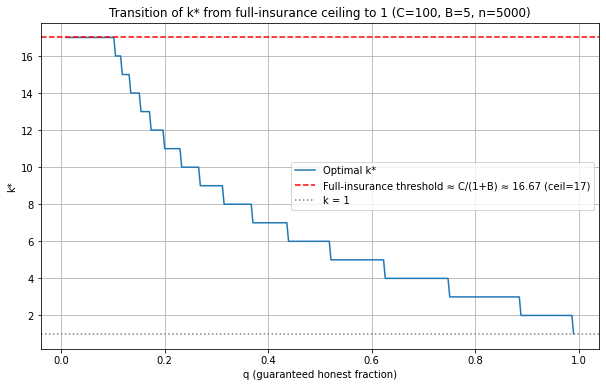

In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Parameters
C = 100
B = 5
n = 5000          # large n so hypergeometric approx is good
k_threshold = C / (1 + B)   # full-insurance threshold (real value)
k_thr_int = math.ceil(k_threshold)

# q range: start low (but above 0) to near 1
q_values = np.linspace(0.01, 0.99, 300)  # from 1% honest guarantee up to 99%

def expected_cost(n, m, C, B, k):
    sybils = n - m
    # exact hypergeometric probability that all k are Sybils
    # P0 = comb(sybils, k) / comb(n, k) if k <= sybils else 0
    if k > sybils:
        P0 = 0.0
    else:
        P0 = math.comb(sybils, k) / math.comb(n, k)
    return P0 * (C - k * B) + (1 - P0) * k

def optimal_k_for_q(q, n, C, B):
    m = int(round(q * n))
    # search up to ceiling threshold
    k_max = min(n, math.ceil(C / (1 + B)))
    best_k, best_cost = None, float("inf")
    for k in range(1, k_max + 1):
        cost = expected_cost(n, m, C, B, k)
        if cost < best_cost - 1e-12:
            best_cost, best_k = cost, k
    return best_k

k_star_vals = [optimal_k_for_q(q, n, C, B) for q in q_values]

plt.figure(figsize=(10,6))
plt.plot(q_values, k_star_vals, label="Optimal k*")
plt.axhline(k_thr_int, color='red', linestyle='--', label=f"Full-insurance threshold ≈ C/(1+B) ≈ {k_threshold:.2f} (ceil={k_thr_int})")
plt.axhline(1, color='gray', linestyle=':', label="k = 1")
plt.xlabel("q (guaranteed honest fraction)")
plt.ylabel("k*")
plt.title(f"Transition of k* from full-insurance ceiling to 1 (C={C}, B={B}, n={n})")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
# comparing lottery and stake and slash

In [34]:
def expected_cost_ss(k, m, n, C, B):
    p0 = math.comb(n - m, k) / math.comb(n, k)
    risk_term = p0 * (C - k * (B + 1))
    return k + risk_term

def expected_cost_lot(p, m, n, C):
    one_minus_p = 1 - p
    term1 = one_minus_p**m * C
    term2 = (1 - one_minus_p**m) * (n * p) / (1 - one_minus_p**n)
    return term1 + term2

In [173]:
C = 3000
B = 2

k_max = int(np.ceil(C / (B + 1)))
k_range = np.arange(1, k_max + 1)
p_grid = np.linspace(1e-6, 1 - 1e-6, 1000)

m = 1500
n = 10000
q = m/n

In [174]:
costs = [expected_cost_ss(k, m, n, C, B) for k in k_range]
idx = int(np.argmin(costs))
opt_costs = costs[idx]
idx, opt_costs, k_max

(37, 43.92670068287021, 1000)

In [175]:
costs = expected_cost_lot(p_grid, m, n, C)
min_idx = int(np.argmin(costs))
p_star = p_grid[min_idx]
Cp_star = costs[min_idx]
p_star, Cp_star

(0.004004995995995996, 47.24485292028858)

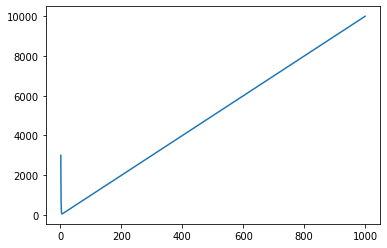

In [176]:
plt.plot(k_range, costs)

# comparison directly.

In [262]:
C = 3000
B = 50

m = 150
n = 3000
q = m/n

In [263]:
def expected_cost_lot(p, m, n, C):
    one_minus_p = 1 - p
    term1 = one_minus_p**m * C
    term2 = (1 - one_minus_p**m) * (n * p) / (1 - one_minus_p**n)
    return term1 + term2

In [264]:
p_grid   = np.linspace(1e-6, 1 - 1e-6, 1000)
lot_cost = expected_cost_lot(p_grid, m, n, C)

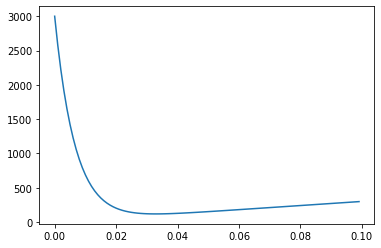

In [265]:
lb, ub = 0, 100
plt.plot(p_grid[lb:ub], lot_cost[lb:ub])

In [266]:
p_star = p_grid[np.argmin(lot_cost)]
p_star, expected_cost_lot(p_star, m, n, C)

(0.03303396696696696, 117.9043872955133)

In [267]:
def expected_cost_ss(k, m, n, C, B):
    p0 = sc.special.comb(n - m, k) / sc.special.comb(n, k)
    risk_term = p0 * (C - k * (B + 1))
    return k + risk_term

In [268]:
k_grid  = np.arange(1, np.ceil(C/(B+1)))
ss_cost = expected_cost_ss(k_grid, m, n, C, B)

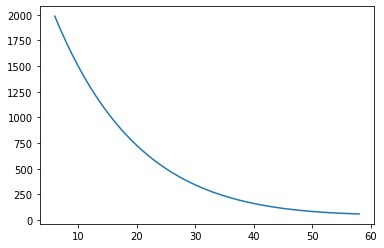

In [271]:
lb, ub = 5, 700
plt.plot(k_grid[lb:ub], ss_cost[lb:ub])

In [272]:
k_star = k_grid[np.argmin(ss_cost)]
k_star, expected_cost_ss(k_star, m, n, C, B)

(58.0, 60.081882506061255)

In [255]:
def getOptLott(m, n, C):
    p_grid   = np.linspace(1e-6, 1 - 1e-6, 1000)
    lot_cost = expected_cost_lot(p_grid, m, n, C)
    p_star = p_grid[np.argmin(lot_cost)]
    return p_star, expected_cost_lot(p_star, m, n, C)

In [273]:
getOptLott(m, n, C)

(0.03303396696696696, 117.9043872955133)

In [257]:
def getOptSS(m, n, C, B):
    k_grid  = np.arange(1, np.ceil(C/(B+1)))
    ss_cost = expected_cost_ss(k_grid, m, n, C, B)
    k_star = k_grid[np.argmin(ss_cost)]
    return k_star, expected_cost_ss(k_star, m, n, C, B)

In [274]:
getOptSS(m, n, C, B)

(58.0, 60.081882506061255)

In [275]:
Cs = np.arange(1000, 5000)

In [276]:
optps, optks = [], []
optLotts, optSS = [], []
for C in Cs:
    ps, lotCost = getOptLott(m, n, C)
    optps.append(ps)
    optLotts.append(lotCost)
    
    ks, ssCost = getOptSS(m, n, C, B)
    optks.append(ks)
    optSS.append(ssCost)

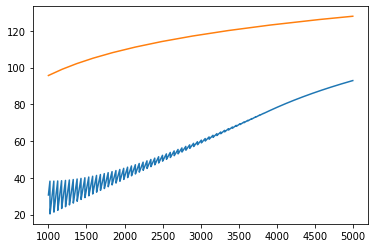

In [282]:
plt.plot(Cs, optSS)
plt.plot(Cs,optLotts)

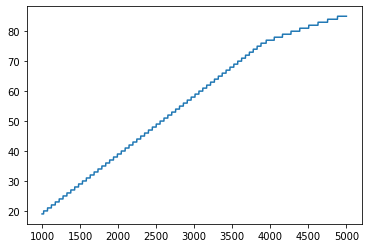

In [278]:
plt.plot(Cs, optks)

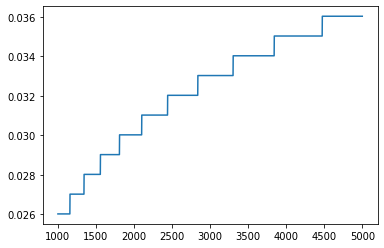

In [279]:
plt.plot(Cs, optps)